## Epidemiology model for spread of COVID-19
### Author: Dr Wladimir Lyra, New Mexico State University




In this code I will use a SEAIR (susceptible-infected-removed, plus exposed and assymptomatic) model. The model traces the evolution of a susceptible population $S$, exposed $E$, infected $I$, and removed population, $R$. The equations are


\begin{eqnarray}
\frac{dS}{dt} &=&-\beta \frac{(I+A) S}{N} \\
\frac{dE}{dt} &=& \beta \frac{(I+A) S}{N} - \sigma E\\
\frac{dA}{dt} &=& (1-p)\sigma E -\theta A\\
\frac{dI}{dt} &=& p\sigma E - \gamma I - \xi I\\
\frac{dH}{dt} &=& \xi I - \eta H \\
\frac{dR}{dt} &=& \gamma I + \theta A + \eta H
\end{eqnarray}

$\beta$ is the infection rate, $\sigma$ is the incubation rate, $\gamma$ is the removal rate of , and $\mu$ is the death rate. 

Contact with infected people removes a fraction of the susceptible population at the rate $\beta I S $, placing them at the infected population. At the same time, the infected population has a recovery rate $\gamma$. 

### The parameter $R_0$

We can gain understanding of the dynamics of the infected population by writing its equation as 

\begin{equation}
\frac{dI}{dt} = \gamma I \left(\frac{\beta}{\gamma} \frac{S}{N} - 1 \right),
\end{equation}

and noticing that in the beggining of the infection, when $S \approx N$ (where $N$ is the size of the population) it reduces to 

\begin{equation}
\frac{dI}{dt} \approx \gamma I \left(\frac{\beta}{\gamma}  - 1 \right).
\end{equation}

The dynamics of the infected population is controled by the parameter 

\begin{equation}
R_0 = \frac{\beta}{\gamma}
\end{equation}

When $R_0 > 1$ the infected population grows exponentially. When $R_0 \leq 1$ the disease is controlled. 

$R_0$ can be thought of as the average number of people an infected person will contaminate before being removed. As such, it is called the basic reproduction number. Social distancing has the effect of lowering the infection rate $\beta$, and thus the basic reproduction number $R_0$. 






### Doubling time and application to current COVID-19 epidemics

Based on  

\begin{equation}
\frac{dI}{dt} \approx \gamma I \left(R_0  - 1 \right)
\end{equation}

we can relate the doubling time of the infection to $R_0$. The e-folding time is 

\begin{equation}
t_e = \frac{1}{\gamma \left(R_0-1\right)}
\end{equation}

So the doubing time is 

\begin{equation}
t_{\rm double} = t_e \ \ln 2 = \frac{\ln 2}{\gamma \left(R_0-1\right)}
\end{equation}


In [1]:
import numpy as np
import pylab as plt
import sys 
#
Tincubation      = 5.2  # length of incubation period
Tinfection       = 2.9  # duration patient is infectious
Tdeath           = 14.  # time from exposure to death
Thospitalization = 5.  # time to hospitalization
Thospitalized    = 10.  # length of hospital stay
R0=2.8
# fraction of symptomatic and asymptomatic cases
p=0.6
# fraction of cases that require hospitalization
# Timescales
sigma = 1./Tincubation
gamma = 1./Tinfection
mu    = 1./Tdeath  
eta   = 1./Thospitalized

theta = mu
tmu = Tdeath

# confinement 
psi = 0.

#
# London study breakdown by age
#
age_bins                     = np.array([10,20,30,40,50,60,70,80,90])
fatality_rate_age            = .01*np.array([0.002,0.006,0.03,0.08,0.15,0.60,2.2,5.1,9.3])
hospitalization_fraction_age = .01*np.array([0.1,0.3,1.2,3.2,4.9,10.2,16.6,24.3,27.3])
critical_care_age            = .01*np.array([5,5,5,5,6.3,12.2,27.4,43.2,70.9])
icu_fraction_age             =  hospitalization_fraction_age*critical_care_age

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE) # controls default text sizes                   
plt.rc('axes', titlesize=MEDIUM_SIZE) # fontsize of the axes title               
plt.rc('axes', labelsize=BIGGER_SIZE) # fontsize of the x and y labels           
plt.rc('xtick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels             
plt.rc('ytick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels             
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize                         
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title         


The next blocks have funtion definitions

In [2]:
def date_to_time(d):
    from datetime import datetime    

    n=len(d)    
    
    date=np.zeros(n)
    for i in range(n):
        date_object = datetime.strptime(d[i], '%m/%d/%y')
        date[i] = datetime.fromisoformat(np.str(date_object)).timestamp()
                  
    return (date-date[n-1])/86400.                

#################################################################    
    
def calc_doubling_time(time,cases):

    exponential_slope = np.gradient(np.log(1.0*cases+1e-10),time) 

    n=len(exponential_slope)
    doubling_time=np.zeros(n)
    for i in range(n):
        if (exponential_slope[i] != 0):
            doubling_time[i] = np.log(2.)/exponential_slope[i]
        else:
            doubling_time[i]=0.0
    
    return doubling_time

#################################################################

def get_fatality_rate(age):
    return np.sum(fatality_rate_age*age)/np.sum(age)

#################################################################

def read_jhu_data(country,mode):
    import csv
    #base='./dat/time_series_19-covid-' 
    #with open(base+mode+'.csv', newline='') as csvfile:
    base='./dat/time_series_covid19_' 
    with open(base+mode+'_global.csv', newline='') as csvfile:    
        datareader = csv.reader(csvfile)#, delimiter=',', quotechar='|')
        data = {} 
        for row in datareader:
            if (row[0] == 'Province/State'):
                n=len(row)
                dates = row[4:n]
                for i in range(len(dates)):
                    data[dates[i]]=0
            else:
                if (row[1]==country):
                    for i in range(len(dates)):
                        if (row[i+4]==''): 
                            row[i+4]='0'                        
                        data[dates[i]] += np.int(row[i+4])
    
    return data,dates                
  
#################################################################    

def read_population_pyramid_data(country):
    import csv
    #base='./dat/time_series_19-covid-' 
    #with open(base+mode+'.csv', newline='') as csvfile:
    if (country!='Korea, South'):
        file='./dat/pop/'+country+'-2019.csv' 
    else:
        file='./dat/pop/SKorea-2019.csv' 
#
    with open(file, newline='') as csvfile:    
        datareader = csv.reader(csvfile)#, delimiter=',', quotechar='|')
        #data = {} 
        population=[]
        for row in datareader:
            if (row[0] != 'Age'):
                population.append(np.int(row[1])+np.int(row[2]))
    
    pop=np.array(population)
    age_brackets=np.zeros(9)
    for i in range(9):
        #print(i,2*i,2*i+1)
        age_brackets[i] = pop[2*i]+pop[2*i+1]
    #add the 90+ to the 80-90    
    age_brackets[8]=age_brackets[8] + np.sum(pop[len(pop)-3:len(pop)-1])
    
    return age_brackets
  
#################################################################    

def appendvalues(S,C,E,A,I,H,R,t,SS,CC,EE,AA,II,HH,RR,tt):
    SS.append(S)
    CC.append(C)    
    EE.append(E)
    AA.append(A)    
    II.append(I)
    HH.append(H)    
    RR.append(R)
    tt.append(t)
    return SS,CC,EE,AA,II,HH,RR,tt    
    
#################################################################
    
def get_data_country(name):

    #dict_confirmed,dates = read_jhu_data(name,'Confirmed')
    #dict_recovered,dates = read_jhu_data(name,'Recovered')
    #dict_deaths,dates    = read_jhu_data(name,'Deaths')

    dict_confirmed,dates = read_jhu_data(name,'confirmed')
    dict_recovered,dates = read_jhu_data(name,'recovered')
    dict_deaths,dates    = read_jhu_data(name,'deaths')
    
    n1=len(dict_confirmed.keys())
    n2=len(dict_recovered.keys())
    if (n1!=n2):
        sys.exit()
    n3=len(dict_deaths.keys())    
    if (n2!=n3):
        sys.exit()
    
    confirmed=np.zeros(len(dates))
    recovered=np.zeros(len(dates))
    deaths   =np.zeros(len(dates))
    for i in range(len(dates)):
        confirmed[i] = dict_confirmed[dates[i]]
        recovered[i] = dict_recovered[dates[i]]
        deaths[i]    = dict_deaths[dates[i]]


    country = dict([
                    ('name',name),
                    ('dates', dates),
                    ('confirmed', confirmed),
                    ('recovered', recovered),
                    ('deaths', deaths),
                   ])        
        
    return country
            

### Death rate 

The last parameter in the model is the death rate. The removed are either recovered/cured (C) or dead (D), according to 

\begin{eqnarray}
D(t) &=& \mu \ I(t-\tau_\gamma)
\end{eqnarray}

where $\mu$ is the death rate. The cured are supposed to have gained immunity and not added again to the susceptible population. Current knowledge of the epidemic seem to imply $\mu$=0.01. 

### Model applied to the current epidemics 

Given a universal $\gamma=0.04$, the model input are the doubling times $t_{\rm double}$ and the initial number of infected $I_0$. Below are the numbers of March 14th for Italy, S. Korea, China, and the USA. The total population is for normalization purposes only. The model assumes N=1 and works with population fractions instead.  




In [3]:
def select_country(name):
    
    import csv
    #import urllib2
    from urllib.request import urlopen
    
    dict_confirmed,dates = read_jhu_data(name,'Confirmed')
    dict_deaths,dates    = read_jhu_data(name,'Deaths')
    
    n1=len(dict_confirmed.keys())
    n2=len(dict_deaths.keys())    
    if (n1!=n2):
        sys.exit()
    
    confirmed=np.zeros(len(dates))
    deaths   =np.zeros(len(dates))
    for i in range(len(dates)):
        confirmed[i] = dict_confirmed[dates[i]]
        deaths[i]    = dict_deaths[dates[i]]

    D0=1.

    #mortality from 
    #populations from population pyramid
    color='black'
    if (name=="China"):
        lockdown = '1/23/20'
        color='blue'
        D0=min(deaths)
        median_age=38.4
    elif (name== "Korea, South"):
        lockdown = '2/18/20'        
        color='orange'
        median_age=40.8
    elif (name == 'Iran'):    
        lockdown = '2/22/20'
        color='green'
        median_age=32.
    elif (name == 'Italy'):
        lockdown = '3/09/20'
        color='red'
        median_age=47.3
    elif (name == 'Denmark'):
        lockdown = '3/11/20'        
        color='purple'
        median_age=41.6
    elif (name == 'Norway'):
        lockdown = '3/12/20'                       
        color='brown'
        median_age=39.2
    elif (name == 'Poland'):
        lockdown = '3/13/20'                               
        color='pink'
        median_age=39.7
    elif (name=="Spain"):
        lockdown = '3/14/20'
        color='grey'   
        median_age=43.1
    elif (name=="US"):
        lockdown = '3/19/20'
        color='magenta'
        median_age=38.2
    elif (name=="Sweden"):
        lockdown = ''
        median_age=40.9
    elif (name=="Brazil"):
        lockdown='3/24/20'
        color='cyan'
        median_age=31.4
    elif (name=="Tunisia"):
        lockdown = ''
        color='black' 
        median_age=31.3
    elif (name=="Germany"):
        lockdown = ''  
        median_age=45.9
    elif (name=="Japan"):
        lockdown = '' 
        median_age=47.3
    elif (name=="France"):
        lockdown = ''  
        median_age=41.2
    elif (name=='Ireland'):
        lockdown = ''  
        median_age=36.5
    elif (name=='Uruguay'):   
        lockdown= ''
        median_age=34.9
    elif (name=='Chile'):
        lockdown= ''
        median_age=33.8   
    elif (name=='India'):
        lockdown= ''
        median_age=26.8
    else:
        print("choose a valid country")
        sys.exit()

    age=read_population_pyramid_data(name)    
    N=np.sum(age)
    fatality_rate            = np.sum(fatality_rate_age           *age)/np.sum(age)
    hospitalization_fraction = np.sum(hospitalization_fraction_age*age)/np.sum(age)
    icu_fraction             = np.sum(icu_fraction_age            *age)/np.sum(age)

    # pick the day of the first death to start the integration; it is the best predictor of what
    # is actually happening in a country;
    if (deaths.max() >= D0):  
        index_D0 = [i for i in range(len(deaths)) if deaths[i] >= D0][0]
    else:
        index_D0 = 0
    date_D0 = dates[index_D0]
    
    days_past=date_to_time(dates)    
    time_D0=days_past[index_D0]
    doubling_time=calc_doubling_time(days_past,confirmed)[len(days_past)-1]    

    country = dict([
                    ('name', name),
                    ('D0',D0),
                    ('N',N),
                    ('days past',days_past),
                    ('cases',confirmed),
                    ('doubling time',doubling_time),
                    ('deaths',deaths),
                    ('time_D0',time_D0),
                    ('index_D0',index_D0),
                    ('lockdown',lockdown),
                    ('color',color),
                    ('fatality_rate',fatality_rate),
                    ('median_age',median_age),
                    ('hospitalization_fraction',hospitalization_fraction),
                    ('icu_fraction',icu_fraction) 
                   ])

    #print("Parameters for:",country['name'])
    #print("Doubling time =",doubling_time," days")
    #print("Fatality rate =",100*fatality_rate," %")
    
    return country


In [4]:
def RK3(f):
    N             = f['N']
    D0            = f['D0']
    time_D0       = f['time_D0']
    iD0           = f['index_D0']
    days_past     = f['days past']
    deaths        = f['deaths']    
    name          = f['name']
    lockdown      = f['lockdown']
    fatality_rate = f['fatality_rate']
    hosp_fraction = f['hospitalization_fraction']
    icu_fraction  = f['icu_fraction'] 
    
    xi = hosp_fraction/Thospitalization
    
    alpha_ts   = np.double([0.   , -5./9.  ,-153./128.])
    beta_ts    = np.double([1./3., 15./16. ,   8./15. ])
    Cdt = 0.5

    #
    # Deaths reflect infections 1/gamma days past
    #
    I0    = (D0/N)/fatality_rate
#    
    cases=np.array(deaths[iD0:len(deaths)-1])
    tpast=days_past[iD0:len(deaths)-1]
    dDdt = np.gradient((1.0*cases/N),tpast)  
    init_beta = R0*gamma
#
#  Timestep defined by the timescale given by the rate of infection 
#
    tau_beta  = 1/init_beta #np.min(1./pastbeta)
    dt = Cdt*tau_beta
#    
# End of epidemics. 
#
    tmax = 6*tmu
#
# Lists to store the populations 
#
    SS=[]  # susceptible
    CC=[]  # confined
    EE=[]  # exposed
    AA=[]  # assymptomatic    
    II=[]  # infected symptomatic
    HH=[]  # hospitalized 
    RR=[]  # removed     
    tt=[]  # time
#
    #SS2=[]
    #EE2=[]
    #AA2=[]    
    #II2=[]
    #RR2=[]
#
# Initial values 1/gamma ago  
#
    I=I0
    C=0.
    E=0.
    A=0.
    H=0.
    R=0.
    S=1-C-E-A-I-H-R
#
    dSdt=0.
    dCdt=0.
    dEdt=0.
    dAdt=0.    
    dIdt=0.
    dHdt=0.    
    dRdt=0.

    #I2=I
    #E2=E
    #A2=A    
    #R2=R
    #S2=S
    
#  Start the integration
    itmax=100000   
#
#  Use t=0 as the time of first death minus 1/gamma
#
    t= time_D0-tmu
    ds=0.
#
    SS,CC,EE,AA,II,HH,RR,tt = appendvalues(S,C,E,A,I,H,R,t,SS,CC,EE,AA,II,HH,RR,tt)
    RRt=[R0]

    #SS2.append(S2)
    #EE2.append(E2)
    #AA2.append(A2)    
    #II2.append(I2)
    #RR2.append(R2)
    
    for it in np.arange(itmax):
#                                                                                
        dt_beta_ts = [i * dt for i in beta_ts]
#                                                                                
        tretarded = t + tmu
        if (tretarded < 0):    
            #beta = np.interp(tretarded,tpast,pastbeta)
            dDdt_ = np.interp(tretarded,tpast,dDdt)            
            Rt = 1/(fatality_rate*gamma) * 1/((A+I)*S) * dDdt_ 
            beta = Rt*gamma
        else:
            beta = beta                    
#
# advance time
#
        for itsub in range(3):
            ds  = alpha_ts[itsub]*ds
            ds  = ds+1.
            t   = t + dt_beta_ts[itsub]*ds
#
# advance quantities
#

        for itsub in range(3):
            dSdt   = alpha_ts[itsub]*dSdt
            dCdt   = alpha_ts[itsub]*dCdt            
            dEdt   = alpha_ts[itsub]*dEdt
            dAdt   = alpha_ts[itsub]*dAdt            
            dIdt   = alpha_ts[itsub]*dIdt
            dHdt   = alpha_ts[itsub]*dHdt            
            dRdt   = alpha_ts[itsub]*dRdt
            
            dSdt = dSdt - beta*(I+A)*S -  psi*S
            dCdt = dCdt                +  psi*S
            dEdt = dEdt + beta*(I+A)*S          -       sigma*E            
            dAdt = dAdt                         + (1-p)*sigma*E - theta*A
            dIdt = dIdt                         +    p *sigma*E           - gamma*I  - xi*I 
            dHdt = dHdt                                                              + xi*I - eta*H
            dRdt = dRdt                                         + theta*A + gamma*I         + eta*H
            
            S = S + dt_beta_ts[itsub]*dSdt
            C = C + dt_beta_ts[itsub]*dCdt            
            E = E + dt_beta_ts[itsub]*dEdt
            A = A + dt_beta_ts[itsub]*dAdt            
            I = I + dt_beta_ts[itsub]*dIdt
            H = H + dt_beta_ts[itsub]*dHdt            
            R = R + dt_beta_ts[itsub]*dRdt
                        
        SS,CC,EE,AA,II,HH,RR,tt = appendvalues(S,C,E,A,I,H,R,t,SS,CC,EE,AA,II,HH,RR,tt)
        RRt.append(Rt)
#               
        ##lockdown_date = datetime.datetime.strptime(lockdown, '%m/%d/%y')
        ##today         = datetime.datetime.today()
        #date1 = datetime.datetime.fromisoformat(np.str(datetime.datetime.strptime(lockdown, '%m/%d/%y'))).timestamp()
        #date2 = datetime.datetime.fromisoformat(np.str(datetime.datetime.today())).timestamp()        
        #tlockdown=(date1-date2)/86400.
        #if (t < tlockdown):    
        #    beta2=beta
        #    itlockdown=it
        #else:
        #    Rt2 = np.median(np.array(RRt[0:itlockdown])) 
        #    beta2 = Rt2*gamma            
        #for itsub in np.arange(0,3):
        #    dSdt   = alpha_ts[itsub]*dSdt
        #    dEdt   = alpha_ts[itsub]*dEdt            
        #    dIdt   = alpha_ts[itsub]*dIdt
        #    dRdt   = alpha_ts[itsub]*dRdt
        #    dSdt = dSdt - beta2*I2*S2
        #    dEdt = dEdt + beta2*I2*S2 - sigma*E2            
        #    dIdt = dIdt               + sigma*E2 - gamma*I2   
        #    dRdt = dRdt                          + gamma*I2
        #    S2 = S2 + dt_beta_ts[itsub]*dSdt
        #    E2 = E2 + dt_beta_ts[itsub]*dEdt            
        #    I2 = I2 + dt_beta_ts[itsub]*dIdt
        #    R2 = R2 + dt_beta_ts[itsub]*dRdt     
        #SS2.append(S2)
        #EE2.append(E2)
        #II2.append(I2)
        #RR2.append(R2)        
#
        if ((it == itmax) or t > tmax):
            print(f'End of simulation at t = {np.int(t):d} days \n')
            #
            #  Separate the removed into recovered and dead according to death rate
            #
        
            #print('Percentage of people who avoided infection, S=',np.int(np.round(100*S)),'%')       
            #print('Percentage of exposed, E=',np.int(np.round(100*E)),'%')       
            #print('Percentage of infectious, I=',np.int(np.round(100*I)),'%')    
            #print('Percentage of removed, R=',np.int(np.round(100*R)),'%\n')
        
            print('Percentage infected at peak of epidemics: ',np.int(np.round(100*np.array(II+AA).max())),'%')
            print('Number of hospitalized at peak of epidemics: ',np.int(np.round(N*np.array(HH).max())))            
            print('Number needing ICU at peak of epidemics: ',np.int(np.round(N*icu_fraction*np.array(HH).max())))
            #print(f'Total number of deaths = {np.int(np.round(D*N)):d}')
            #print(f'Total number of deaths averted = {np.int(np.round((D2-D)*N)):d}')

            break
            
    results = dict([('Susceptible', SS),
                    ('Confined', CC),
                    ('Exposed', EE),
                    ('Asymptomatic',AA),
                    ('Infectious', II), 
                    ('Hospitalized', HH),                     
                    ('Removed', RR),
                    ('RRt',RRt),
                    #('S2', SS2),('E2', EE2),('I2', II2), ('R2', RR2),                    
                    ('Time',tt)])
        
    #plt.plot(tt,RRt)    
        
    return results

In [5]:
 def plottage(country,results):

    import matplotlib.dates as mdates
    
    t=np.array(results['Time'])    
    S=np.array(results['Susceptible'])
    C=np.array(results['Confined'])    
    E=np.array(results['Exposed'])
    A=np.array(results['Asymptomatic'])    
    I=np.array(results['Infectious'])
    H=np.array(results['Hospitalized'])    
    R=np.array(results['Removed'])
#   
    N             = country['N']
    deaths        = country['deaths']
    days_past     = country['days past']
    D0            = country['D0']
    name          = country['name']
    lockdown      = country['lockdown']
    fatality_rate = country['fatality_rate']    
#
    strS    = 'Susceptible'
    strC    = 'Confined'    
    strE    = 'Exposed'    
    strA    = 'Asymptomatic'    
    strI    = 'Infectious'
    strR    = 'Removed'
    strH    = 'Hospitalized'    
    strD    = 'Dead'
    strII   = 'Infections'
    strDD   = 'Deaths'
    strdt   = 'Doubling Time'
    strdays = 'days'
    strDays = 'Days'
    strPop  = 'Percentage of Population (%)'
    strCas  = 'Cummulative # of Cases'

    #fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=[15,15])
    
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=[15,15],sharex=True)

# Evolution of the populations

    n=len(S)
    
    cumm_cases=1-S #E+I+R    
    D= np.zeros(n)
    tretarted = t + tmu
    cumm_cases_prior = np.interp(t,tretarted,cumm_cases)
    D = fatality_rate*cumm_cases_prior
    print("Number of dead:",np.round(N*D[n-1]))
    datelist=[]
    for i in range(len(t)):
        datelist.append(datetime.datetime.today() + datetime.timedelta(days=t[i]))
        
    date64=np.array(datelist, dtype='datetime64')         
    date=date64.astype('O')
    
    ax1.plot(date,100*S,color='green'  ,label=strS)
    ax1.plot(date,100*C,color='grey'   ,label=strC)    
    ax1.plot(date,100*E,color='magenta',label=strE)
    ax1.plot(date,100*A,color='purple' ,label=strA)    
    ax1.plot(date,100*I,color='orange' ,label=strI)
    ax1.plot(date,100*H,color='cyan'   ,label=strH)    
    ax1.plot(date,100*R,color='blue'   ,label=strR)
    
    #ax1.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    
# Cumulative number of infections and deaths 
    ax2.plot(date,N*(1-S),color='orange',label="# of Cases (Model with Intervention)")
    itD0     = [i for i in range(n) if D[i] >= (D0+1)/N][0] 
    ax2.plot(date[itD0-1:n-1],N*D[itD0-1:n-1],color='black',label="Deaths (Model with Intervention)")
    
    pastdatelist=[]
    for i in range(len(days_past)):
        pastdatelist.append(datetime.datetime.today() + datetime.timedelta(days=days_past[i]))
    pastdate64=np.array(pastdatelist, dtype='datetime64')         
    pastdate=pastdate64.astype('O')    
    ax2.plot(pastdate,country['cases'],'o',color='orange',label='Confirmed Cases')
    ax2.plot(pastdate,country['deaths'],'o',color='black',label='Deaths')
    ax2.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
#
    #S2=np.array(results['S2'])
    #E2=np.array(results['E2'])    
    #I2=np.array(results['I2'])
    #R2=np.array(results['R2'])
    #ax1.plot(date,100*S2,color='green'  ,linestyle=':')
    #ax1.plot(date,100*E2,color='magenta',linestyle=':')    
    #ax1.plot(date,100*I2,color='orange' ,linestyle=':')
    #ax1.plot(date,100*R2,color='blue'   ,linestyle=':')
    #cumm2_cases=E2+I2+R2    
    #D2= np.zeros(n)
    #tretarted = t + tmu
    #cumm2_cases_prior = np.interp(t,tretarted,cumm2_cases)
    #D2 = fatality_rate*cumm2_cases_prior    
    #print("Number of dead - no intervention:",np.round(N*D2[n-1]))   
    #print("Number of dead averted:",np.round(N*(D2[n-1]-D[n-1])))   
    #ax2.plot(date,N*(E2+I2+R2+D2),color='orange',label="# of Cases (Model without Intervention)",linestyle=":")
    #ax2.plot(date[itD0-1:n-1],N*D2[itD0-1:n-1],color='black',label="Deaths (Model without Intervention)",linestyle=":")    
    
# Annotations and prettifying 

    ax1.set_ylabel(strPop)
    ax1.legend(loc="best",fancybox=True,shadow=True)
    title=name+" Populations"
    
    ax1.axvline(datetime.datetime.today(),linestyle='--',color='black')
    ax1.annotate('Today', xy=(datetime.datetime.today(), 80),rotation=-90,color='black')
    
    ax1.set_title(title)
    ax1.grid()

    ax2.set_yscale("log")
    ax2.set_ylim([1,1.5*N])
    #ax2.set_xlim(['2020-03-10','2020-03-30'])
    ax2.set_ylabel(strCas)
    title=name+" Cumulative"#+", $N$="+strlog+", $I_{tot}$="+np.str(np.int(I0))
    ax2.set_title(title)

    #ax2.axvline(datetime.datetime.today(),linestyle='--',color='black')
    #ax2.annotate('Today', xy=(datetime.datetime.today(), 1e5),rotation=-90,color='black')
        
    ax2.legend(loc="best",fancybox=True,shadow=True)
    ax2.grid()
    
    if (lockdown!=''):
        date_object = datetime.datetime.strptime(lockdown, '%m/%d/%y')
        ax2.axvline(date_object,linestyle=':',color='red')
        ax2.annotate('Lockdown', xy=(date_object, 5e1),rotation=-90,color='red')

        ax2.axvline(date_object+datetime.timedelta(days=+Tdeath),linestyle='--',color='red')
        ax2.annotate(np.str(np.int(np.round(Tdeath)))+'days after\nlockdown', 
            xy=(date_object+datetime.timedelta(days=+Tdeath), 5e1),
            rotation=-90,
            color='red')    
 

    startdate=date[0]
    #enddate   = datetime.datetime.strptime('5/01/20', '%m/%d/%y')
    if (name=="China" or name=="Denmark"):
        endd='5/01/20'
    #elif (name=="Italy"):
    else:    
        endd='6/15/20'
        
    enddate   = datetime.datetime.strptime(endd, '%m/%d/%y')
    ax1.set_xlim([startdate,enddate])
    ax2.set_xlim([startdate,enddate])

    #fig.autofmt_xdate()
    
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    #plt.show()
    plt.savefig("./figs/"+name+"_"+np.str(datetime.date.today())+".png")

    return 

### Integration

We now solve the system of differential equations with a Runge-Kutta algorithm. The timescales of the model are the infection time, given by the inverse of the infection rate 

\begin{equation}
\tau_\beta = \frac{1}{\beta}
\end{equation}

and the inverse of the recovery rate, which is the timescale of the duration of the epidemics.  

\begin{equation}
\tau_\gamma = \frac{1}{\gamma}
\end{equation}

We take timesteps of half a $\tau_\beta$, and model up to 100 days for fast doubling times ($<10$ days), and 18 months (540 days) for longer, which is the estimated time to develop a vaccine. The universal parameters are: 

#### Running the model

The block below runs the models, per country.

End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  0 %
Number of hospitalized at peak of epidemics:  2492
Number needing ICU at peak of epidemics:  39
End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  0 %
Number of hospitalized at peak of epidemics:  431
Number needing ICU at peak of epidemics:  9
End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  4 %
Number of hospitalized at peak of epidemics:  89508
Number needing ICU at peak of epidemics:  881
End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  6 %
Number of hospitalized at peak of epidemics:  208057
Number needing ICU at peak of epidemics:  6815
End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  12 %
Number of hospitalized at peak of epidemics:  37521
Number needing ICU at peak of epidemics:  1006
End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  0 %
Number of hospitaliz

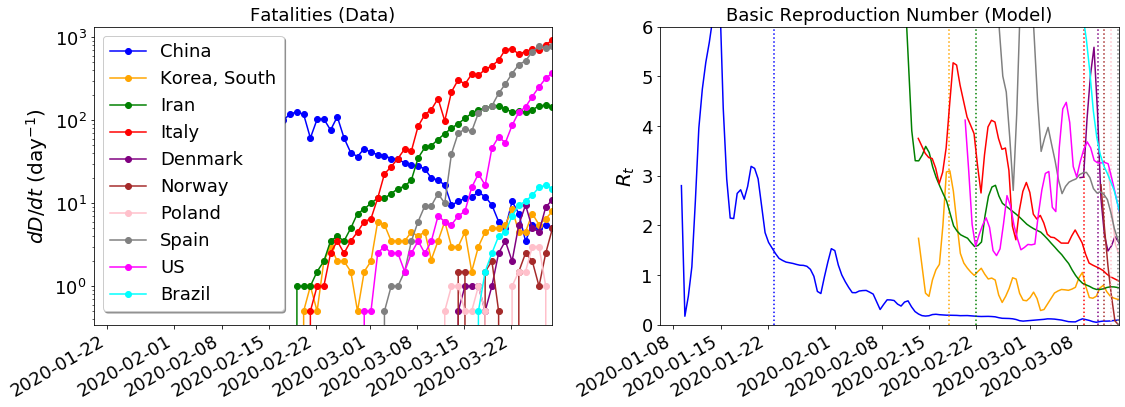

In [6]:
import matplotlib.dates as mdates

fig, (ax1,ax2) = plt.subplots(1,2,figsize=[16,6])

#fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[16,6])

country_list=['China','Korea, South','Iran','Italy','Denmark','Norway','Poland','Spain','US','Brazil']

for i in range(len(country_list)): 
    country = select_country(country_list[i])
    N=country['N']
    lockdown=country['lockdown']
    f=RK3(country)
    t=np.array(f['Time'])  
    color=country['color']
    median_age=country['median_age']
    fatality_rate=country['fatality_rate']    
    
    deaths    = country['deaths']
    tdeaths   = country['days past']
    #lockdown  = country['lockdown']
    #print(country_list[i],deaths)
    iD0 = [i for i in range(len(deaths)) if deaths[i] > 10][0]    
    time_D0=tdeaths[iD0] # tretare
    
    Rt=np.array(f['RRt'])   
    #print(country_list[i],Rt)
        
    t                = np.array(f['Time'])
    n=len(t)
    tretarded        = t + tmu
    itD0 = [i for i in range(n) if tretarded[i] >= time_D0][0]

    datelist=[]
    for k in range(len(t)):
        datelist.append(datetime.datetime.today() + datetime.timedelta(days=t[k]))        
    date64=np.array(datelist, dtype='datetime64')         
    date=date64.astype('O')    
    datelist=[]
    for k in range(len(tdeaths)):
        datelist.append(datetime.datetime.today() + datetime.timedelta(days=tdeaths[k]))        
    date64=np.array(datelist, dtype='datetime64')         
    datedeaths=date64.astype('O')    
    
    #ax1.plot(tdeaths,np.gradient(deaths,tdeaths),'-o',label=country_list[i])    
    ax1.plot(datedeaths,np.gradient(deaths,tdeaths),'-o',label=country_list[i],color=color)        
    #ax2.plot(t[itD0:n-1],Rt[itD0:n-1],label=country_list[i])
    ax2.plot(date[itD0:n-1],Rt[itD0:n-1],label=country_list[i],color=color)    
    lockdown_date = datetime.datetime.strptime(lockdown, '%m/%d/%y')
    ax2.axvline(lockdown_date,linestyle=':',color=color)    

    #ax3.plot(median_age,fatality_rate,'o',color=color)
    
#plt.legend()    
#ax1.fmt_xdata = mdates.DateFormatter('%m/%d/%y')
#ax2.fmt_xdata = mdates.DateFormatter('%m/%d/%y')

ax2.set_ylim([0,6])
#ax2.set_xlim([-70,-Tdeath])

ax1.set_yscale("log")
ax1.legend(loc='best',fancybox='True',shadow='True')
#ax2.legend(loc='best',fancybox='True',shadow='True')

ax1.set_title('Fatalities (Data)')
ax1.set_ylabel(r'$dD/dt$ (day$^{-1}$)')

ax2.set_title('Basic Reproduction Number (Model)')
ax2.set_ylabel(r'$R_t$')

startdate = datetime.datetime.strptime('1/20/20', '%m/%d/%y')
today     = datetime.datetime.today()
ax1.set_xlim([startdate                                ,today                                ])
ax2.set_xlim([startdate-datetime.timedelta(days=Tdeath),today-datetime.timedelta(days=Tdeath)])
#ax2.set_xlim([datetime.datetime.strptime('2/14/20', '%m/%d/%y'),today-datetime.timedelta(days=Tdeath)])

plt.xticks(rotation=45)
fig.autofmt_xdate()

#ax3.set_xlim([20,50])
#ax3.set_ylim([1e-4,3e-2])

plt.tight_layout()

#
#fig.autofmt_xdate()
#
#plt.show()
#
plt.savefig("Rt_data_model.pdf")
#

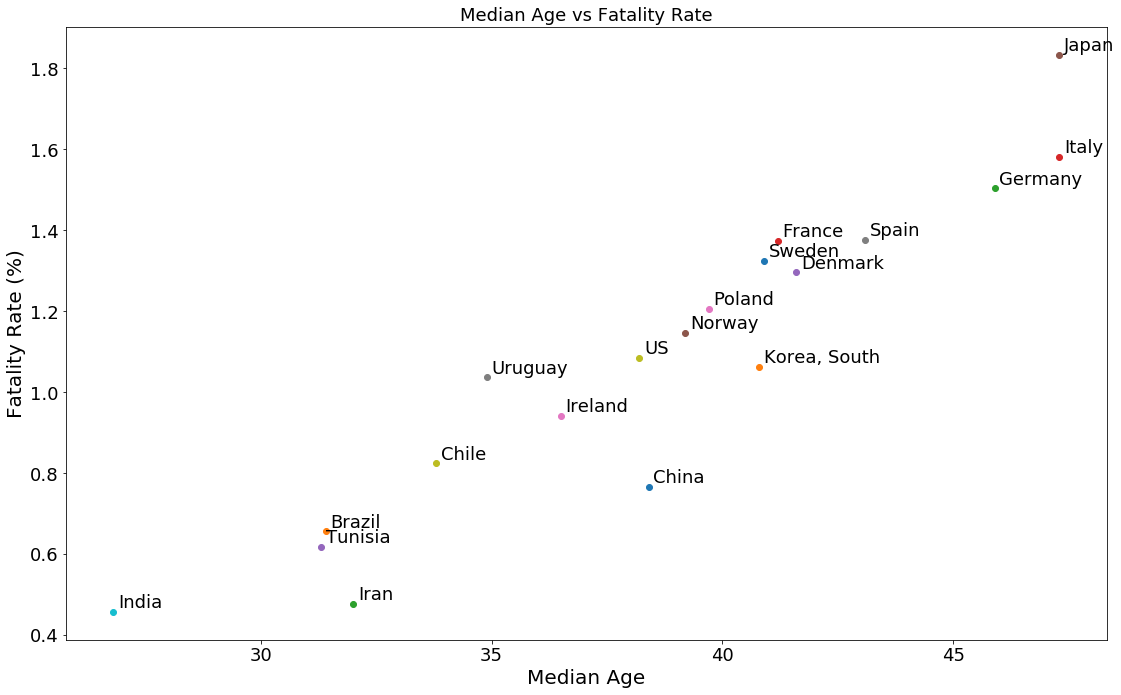

In [7]:
import matplotlib.dates as mdates

fig, (ax1) = plt.subplots(1,1,figsize=[16,10])

country_list=['China','Korea, South','Iran','Italy','Denmark','Norway','Poland','Spain','US','India',
              'Sweden','Brazil','Germany','France','Tunisia','Japan','Ireland','Uruguay','Chile']
for i in range(len(country_list)): 
    country = select_country(country_list[i])
    median_age=country['median_age']
    fatality_rate=country['fatality_rate']    
    
    ax1.plot(median_age,100*fatality_rate,'o')
    ax1.annotate(country_list[i],xy=(median_age+0.1,100*fatality_rate+0.01))
    
ax1.set_title('Median Age vs Fatality Rate')
ax1.set_ylabel('Fatality Rate (%)')
ax1.set_xlabel('Median Age')

plt.tight_layout()

#plt.show()
plt.savefig("MedianAge_FatalityRate.pdf")


End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  0 %
Number of hospitalized at peak of epidemics:  2492
Number needing ICU at peak of epidemics:  39
Number of dead: 3474.0


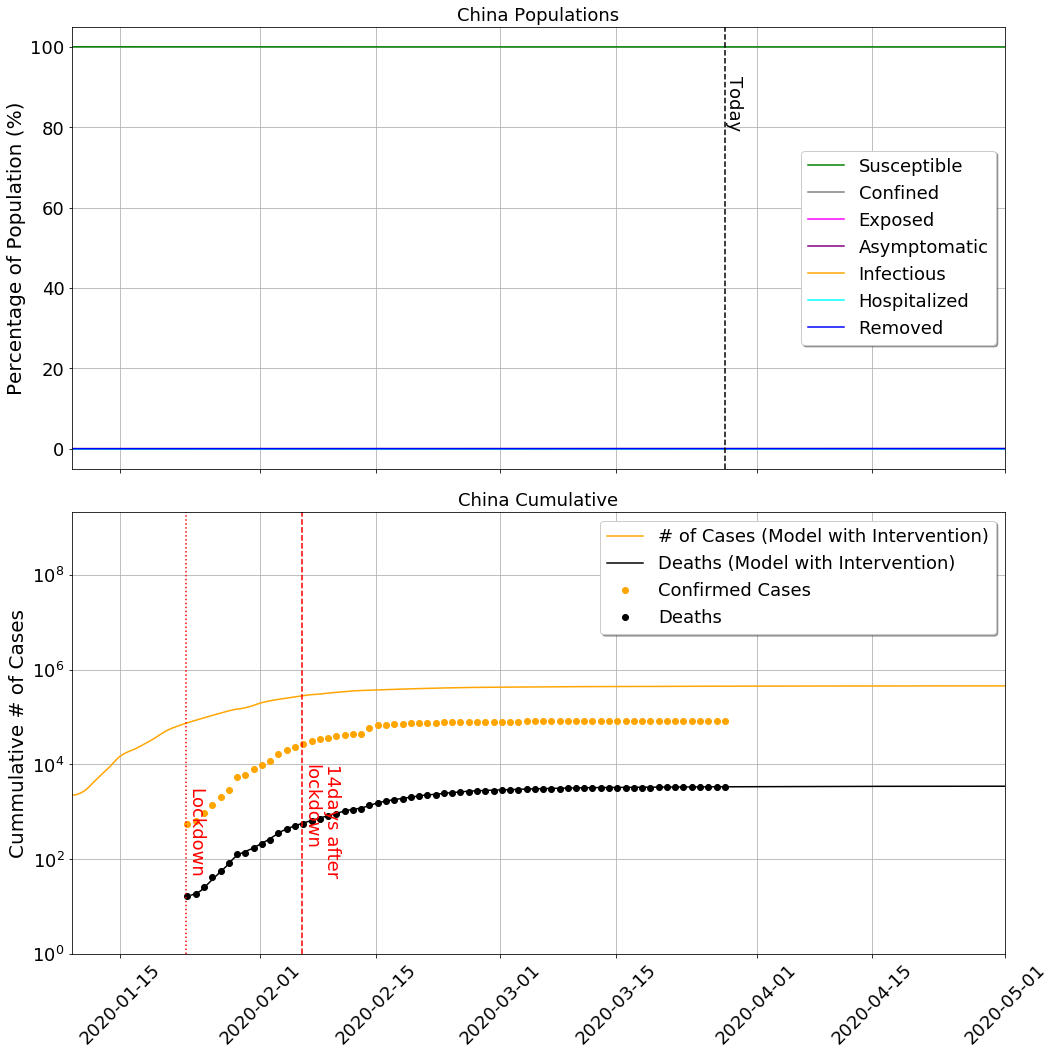

In [8]:
country = select_country('China')
plottage(country,RK3(country))

End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  0 %
Number of hospitalized at peak of epidemics:  431
Number needing ICU at peak of epidemics:  9
Number of dead: 1026.0


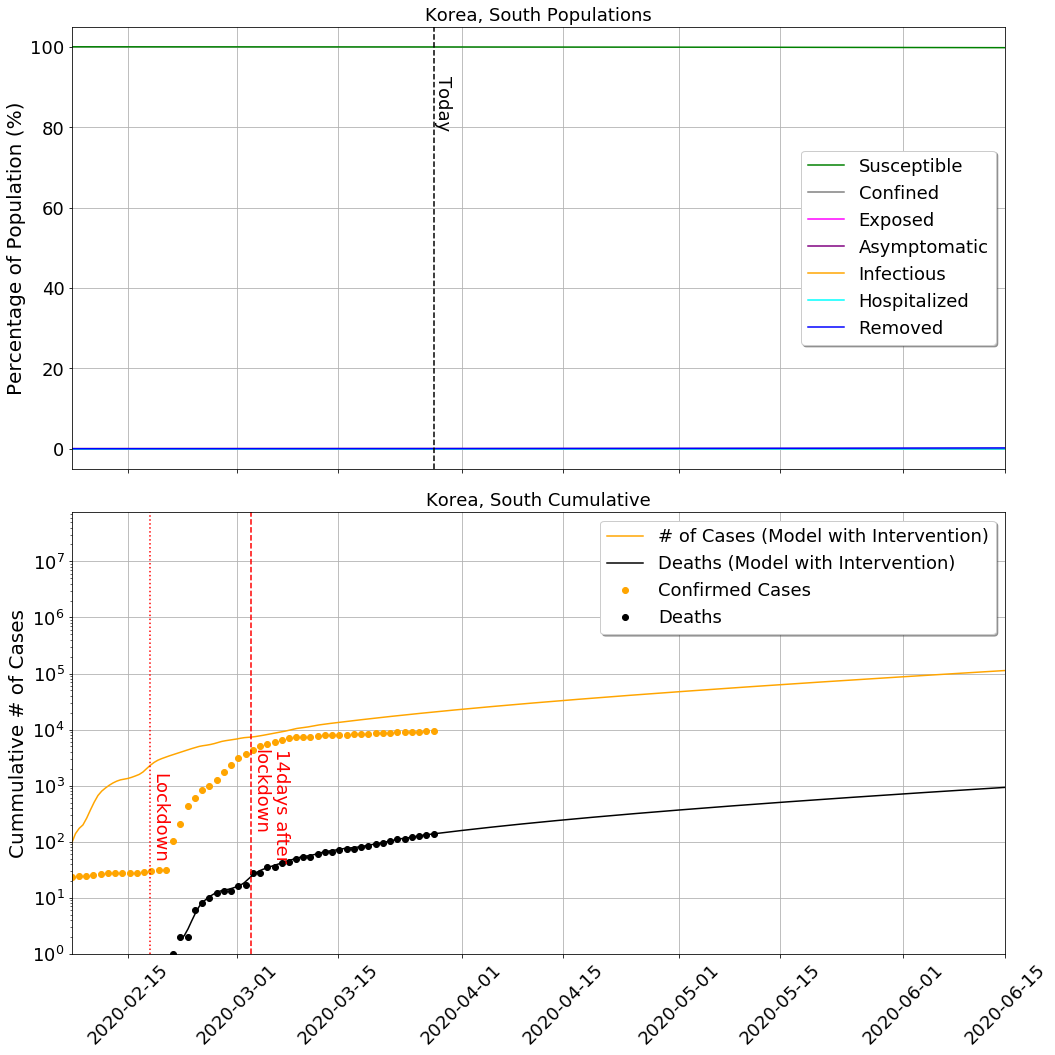

In [9]:
country = select_country('Korea, South')
plottage(country,RK3(country))


End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  6 %
Number of hospitalized at peak of epidemics:  208057
Number needing ICU at peak of epidemics:  6815
Number of dead: 567756.0


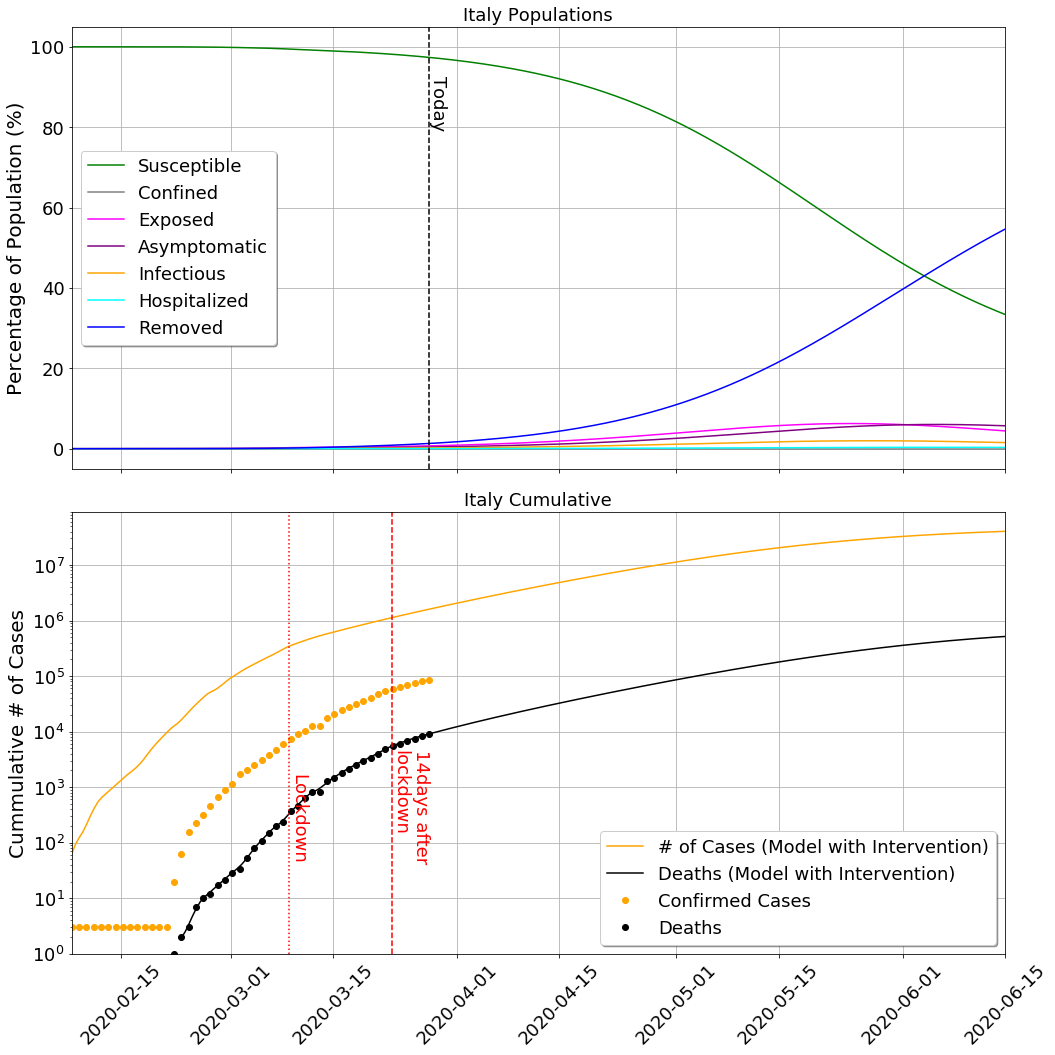

In [10]:
country = select_country('Italy')
plottage(country,RK3(country))

End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  4 %
Number of hospitalized at peak of epidemics:  89508
Number needing ICU at peak of epidemics:  881
Number of dead: 104925.0


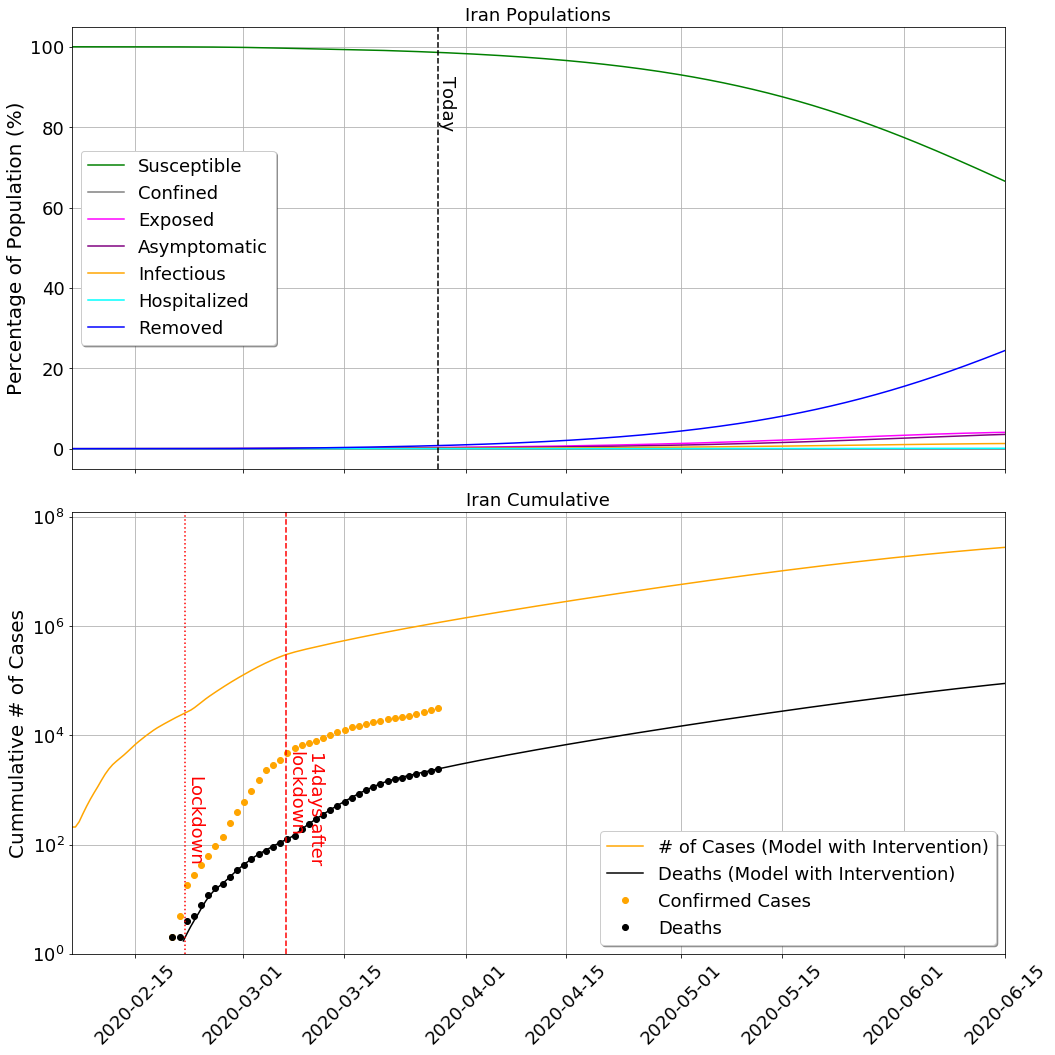

In [11]:
country = select_country('Iran')
plottage(country,RK3(country))

End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  12 %
Number of hospitalized at peak of epidemics:  37521
Number needing ICU at peak of epidemics:  1006
Number of dead: 70732.0


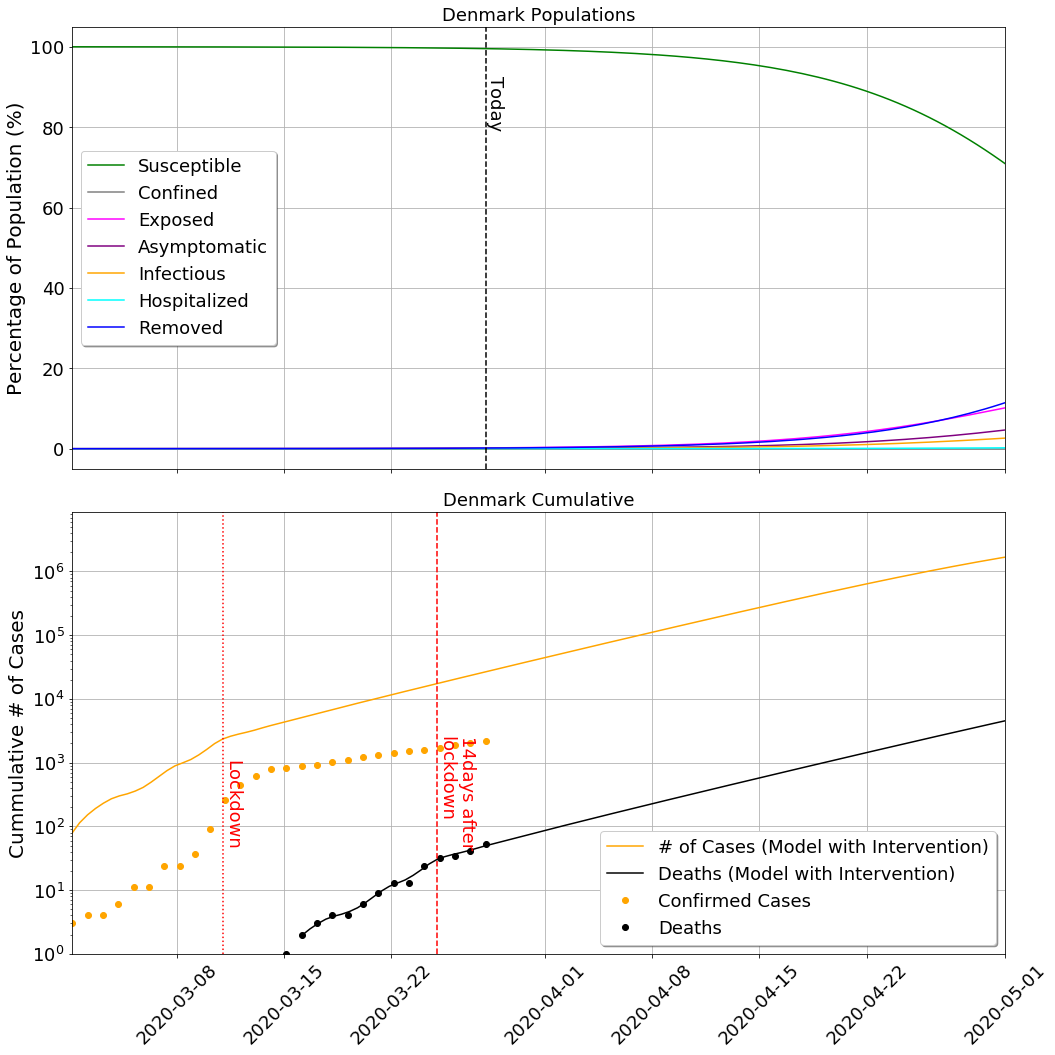

In [12]:
country = select_country('Denmark')
plottage(country,RK3(country))

In [13]:
##country = select_country('El Salvador')
##plottage(country,RK3(country))

In [14]:
#country = select_country('Ireland')
#plottage(country,RK3(country))

End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  0 %
Number of hospitalized at peak of epidemics:  12
Number needing ICU at peak of epidemics:  0
Number of dead: 13.0


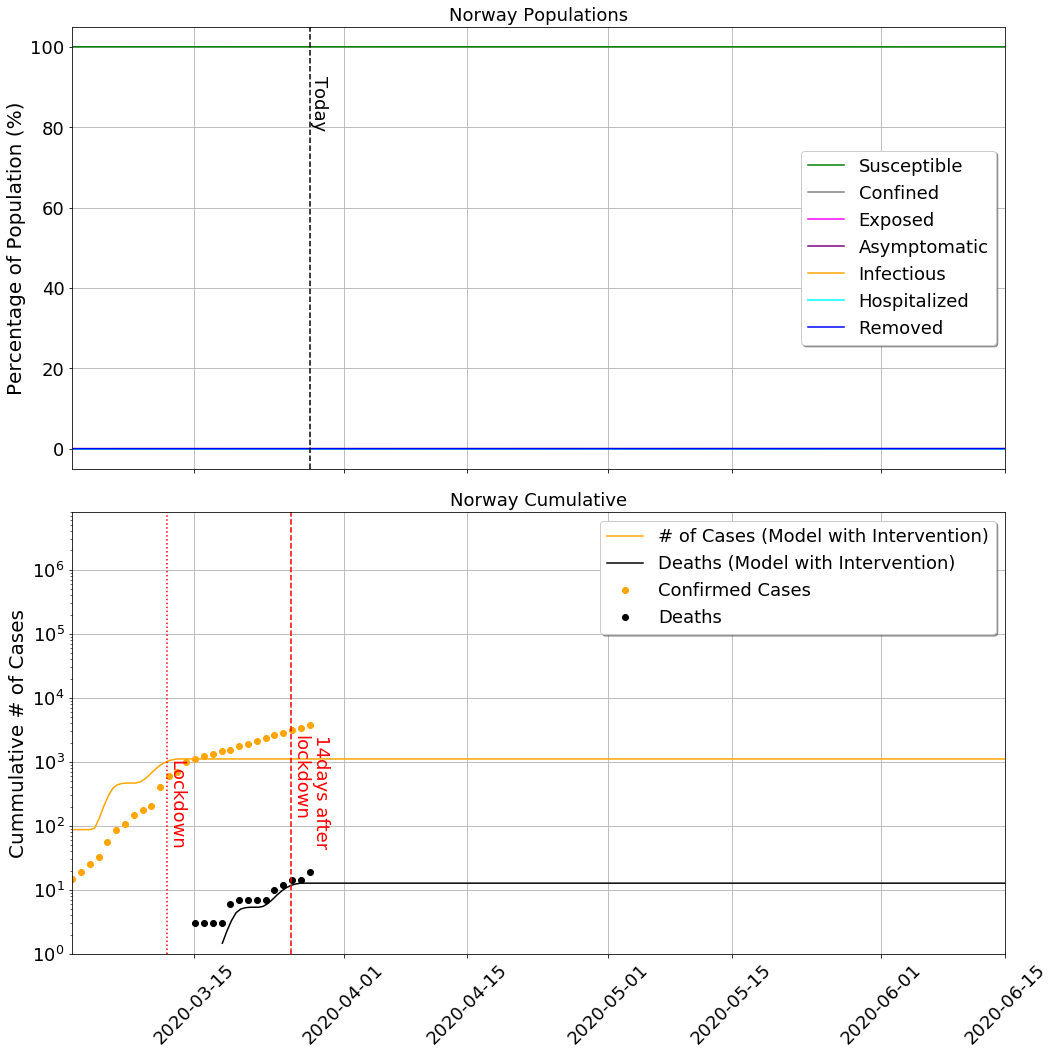

In [15]:
country = select_country('Norway')
plottage(country,RK3(country))

In [16]:
#country = select_country('Poland')
#plottage(country,RK3(country))

End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  13 %
Number of hospitalized at peak of epidemics:  321246
Number needing ICU at peak of epidemics:  9157
Number of dead: 625229.0


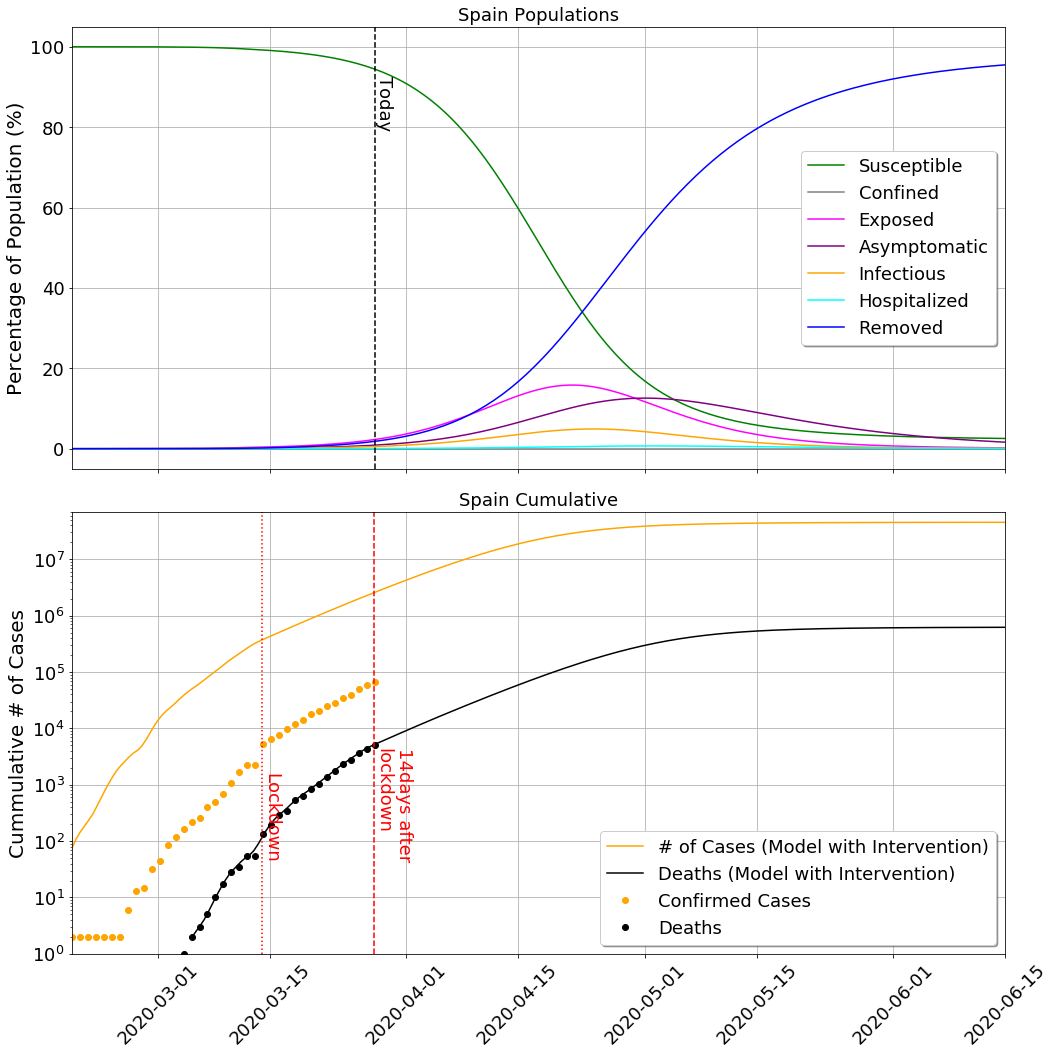

In [17]:
country = select_country('Spain')
plottage(country,RK3(country))

End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  15 %
Number of hospitalized at peak of epidemics:  1164415
Number needing ICU at peak of epidemics:  15788
Number of dead: 1369942.0


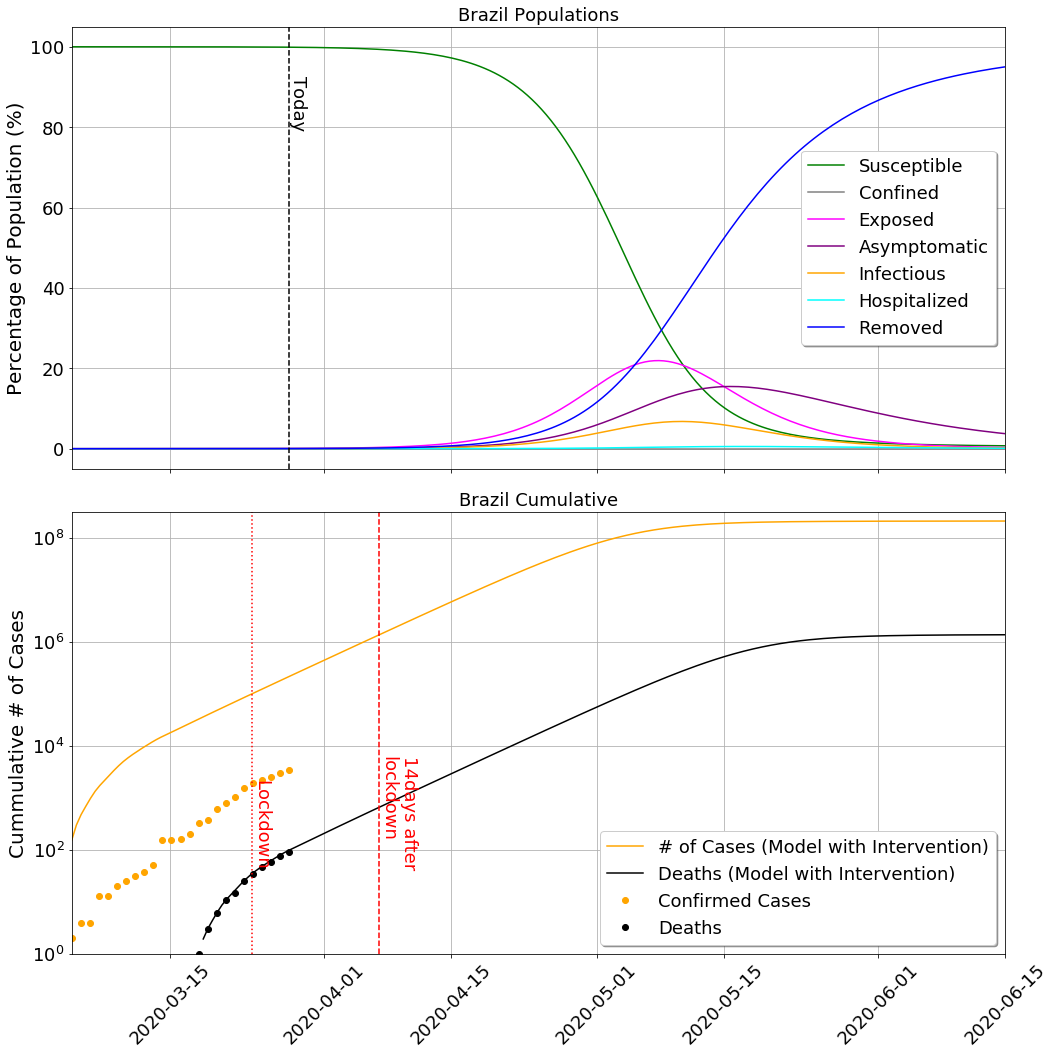

In [18]:
country = select_country('Brazil')
plottage(country,RK3(country))

End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  15 %
Number of hospitalized at peak of epidemics:  2371764
Number needing ICU at peak of epidemics:  53204
Number of dead: 3535531.0


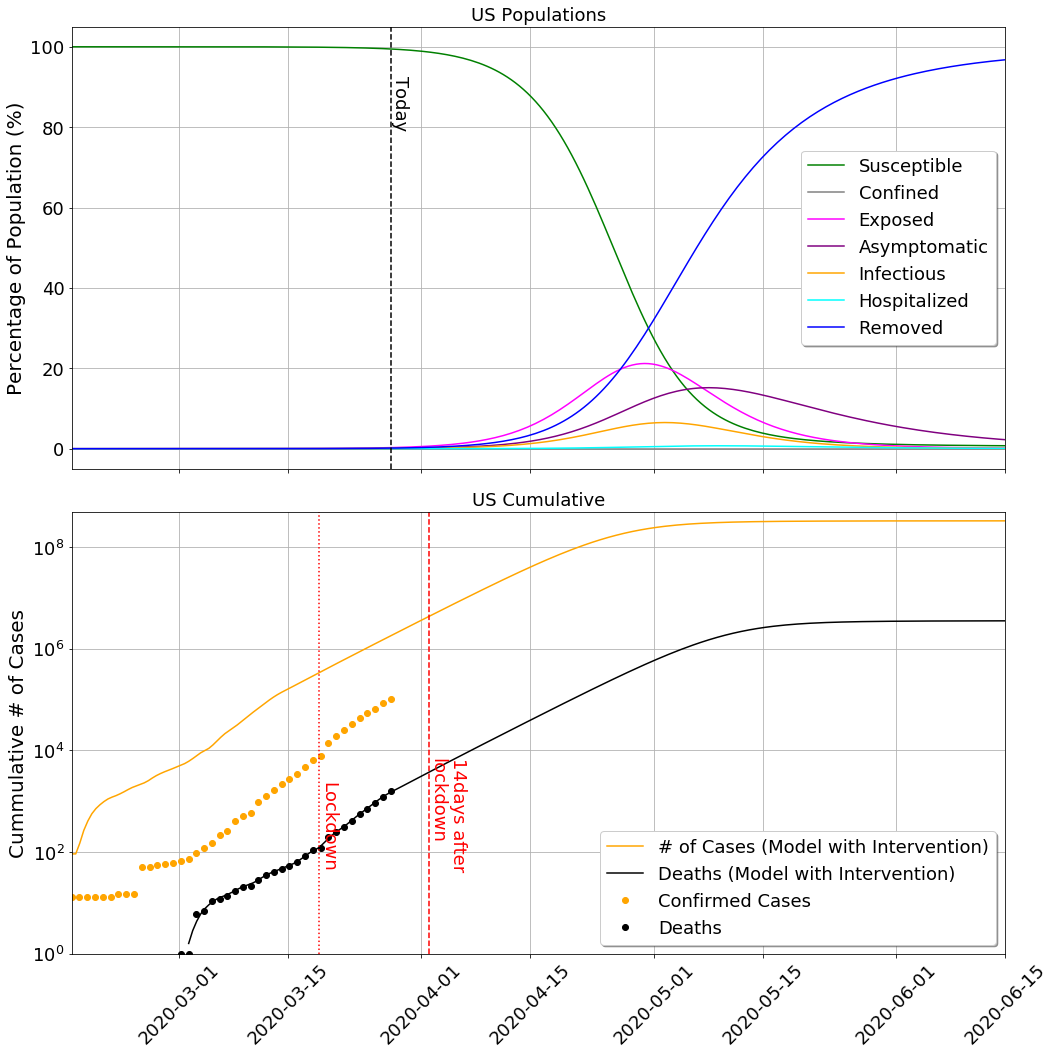

In [19]:
country = select_country('US')
plottage(country,RK3(country))

End of simulation at t = 84 days 

Percentage infected at peak of epidemics:  14 %
Number of hospitalized at peak of epidemics:  57422
Number needing ICU at peak of epidemics:  733
Number of dead: 70212.0


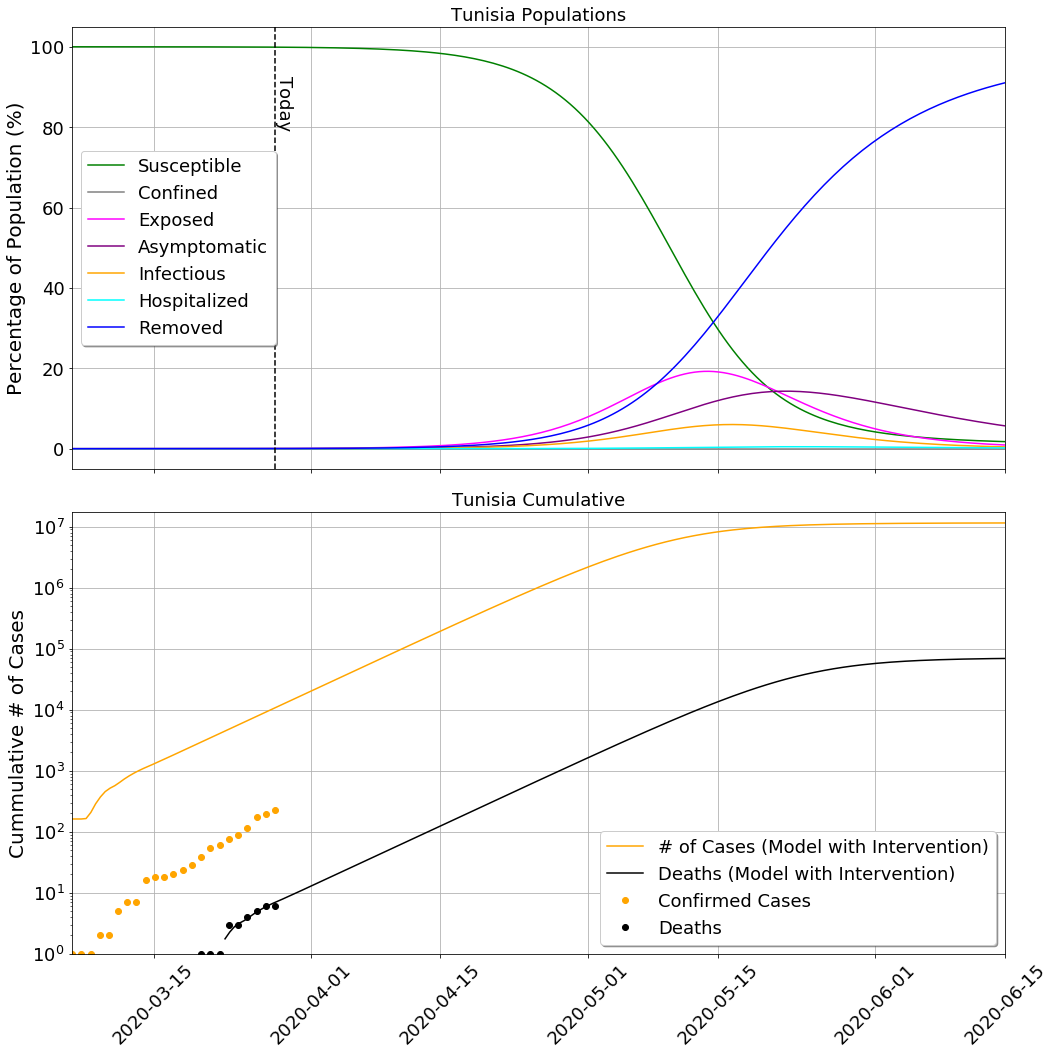

In [20]:
country = select_country('Tunisia')
plottage(country,RK3(country))

### Conclusions

This is the result of only a few hours of learning about modeling epidemiology; I do not claim the model is accurate. WHO is using a similar base model but with much more sophistication such as incubation period, transport between populations, birth and death rates, introduction of virus by the animal source, etc. For instance, $\beta$, the infection rate, depends on parameters of the population as well, like mobility. As such, it varies spatially. There's this 2D model here, applied to a city (Yerevan). 

https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2

And here a 1D model solving for the populations of the animal vectors (presumably bats and including unidentified 'hosts') and people (BHRP model, for bats-hosts-reservoir-people). 

https://idpjournal.biomedcentral.com/articles/10.1186/s40249-020-00640-3


Still, the toy model in this notebook gives a good insight on the dynamics of the epidemics, and how social distancing works on stalling it and reducing the infection and death rate. 

# Stay home, everyone.




### References 

More on the model can be found here, and references therein. 

https://idpjournal.biomedcentral.com/articles/10.1186/s40249-020-00640-3

https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model

https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2
    